In [1]:
import os
import sys
path_1 = os.path.dirname(os.getcwd())
path_2 = path_1 + '/' + 'CommonCodes/'
sys.path.insert(0, path_2)

import warnings
import operator
import numpy as np
import import_ipynb
import pandas as pd
from sklearn.svm import SVC
from collections import Counter
import matplotlib.pyplot as plt
import HelperFunctions as helper
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV


warnings.filterwarnings("ignore")

In [2]:
_USE_FIRST_N_GENES_CONF = 40 
_USE_FIRST_N_GENES_ALL = 100

selected_genes = ['TP53', 'APC', 'KRAS', 'MGMT', 'SMAD2', 'SMAD4', 'label']

train_datasets_names = ['GSE21510', 'GSE44076_normal', 'GSE44861', 'GSE68468', 'GSE89287', 'GSE103512']
test_datasets_names = ['GSE25070', 'GSE24514', 'GSE39582', 'GSE113513', 'GSE41657', 'GSE110225', 'GSE13294', 'GSE13067', 'GSE14333', 'GSE17536', 'GSE2109', 'GSE35896']
all_datasets = train_datasets_names + test_datasets_names

_test_datasets = []
for d in test_datasets_names:
    _test_datasets.append(pd.read_pickle(path_1+'/Datasets/'+d))

_train_datasets = []
for d in train_datasets_names:
    _train_datasets.append(pd.read_pickle(path_1+'/Datasets/'+d))

for i in range(len(_test_datasets)):
    _test_datasets[i] = _test_datasets[i].groupby(_test_datasets[i].columns, axis=1).agg(np.mean)[selected_genes]
    _test_datasets[i].columns = np.arange(len(_test_datasets[i].columns))

for i in range(len(_train_datasets)):
    _train_datasets[i] = _train_datasets[i].groupby(_train_datasets[i].columns, axis=1).agg(np.mean)[selected_genes]
    _train_datasets[i].columns = np.arange(len(_train_datasets[i].columns))

df_train = pd.concat(_train_datasets)

df_train = helper.oversample(df_train).sample(frac=1).reset_index(drop=True)

x_train, y_train = helper.datasetXY_S(df_train)

for i in range(len(_test_datasets)):
    x, y = helper.datasetXY_S(_test_datasets[i])
    x = pd.DataFrame(x.apply(helper.minmax_scaler, axis=1).values.tolist(), columns=x.columns)
    scaled_df = helper.datasetXY_M(x, y)
    _test_datasets[i] = scaled_df.copy()

x_train = pd.DataFrame(x_train.apply(helper.minmax_scaler, axis=1).values.tolist(), columns=x_train.columns)

In [3]:
f1_scores = []
accuracies = []
confusions = []
recall_scores = []
specificity_scores = []
    
rf_model = RandomForestClassifier(n_estimators=300)
lr_model = LogisticRegression()
svm_model = CalibratedClassifierCV(SVC(kernel='poly'), cv=5)
rf_model.fit(x_train, y_train)
lr_model.fit(x_train, y_train)
svm_model.fit(x_train, y_train)
n_genes_accs = []
n_genes_f1 = []
n_genes_recall = []
n_genes_specificity = []

for curr_test_set_index in range(len(_test_datasets)):
    x_test, y_test = helper.datasetXY_S(_test_datasets[curr_test_set_index])
    
    rf_pred_proba = rf_model.predict_proba(x_test)
    lr_pred_proba = lr_model.predict_proba(x_test)
    svm_pred_proba = svm_model.predict_proba(x_test)
    ensemble_pred_probs = np.mean([rf_pred_proba, lr_pred_proba, svm_pred_proba], axis=0)
    ensemble_preds = helper.probToDummy(ensemble_pred_probs)[:,1]
    ensemble_preds = [int(x) for x in ensemble_preds]
    cm = confusion_matrix(y_test, ensemble_preds)
    if cm.shape != (2, 2):
        case_or_control_num = cm[0,0]
        cm = [[0,0],[0,0]]
        if y_test[1] == 1 and ensemble_preds[1] == 1:
            cm = [[0,0],[0,case_or_control_num]]
        else:
            cm = [[case_or_control_num,0],[0,0]]
    cm = np.array(cm)
    TN = cm[0,0]
    FP = cm[0,1]
    FN = cm[1,0]
    TP = cm[1,1]
    if TP+FN!=0 and TN+FP==0:
        n_genes_recall.append(TP/(TP+FN))     
    if TN+FP!=0 and TP+FN==0:
        n_genes_specificity.append(TN/(TN+FP))
    
    confusions.append(cm.copy())

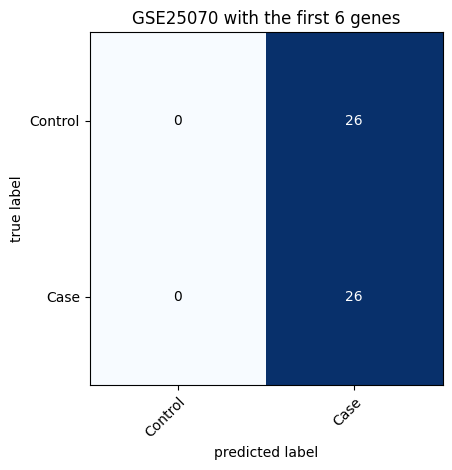

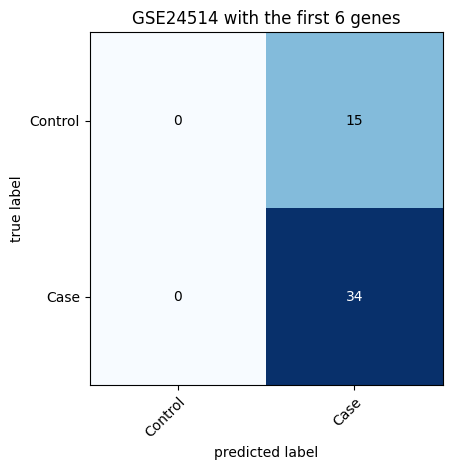

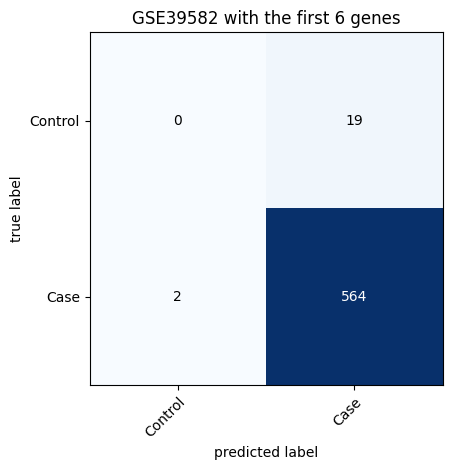

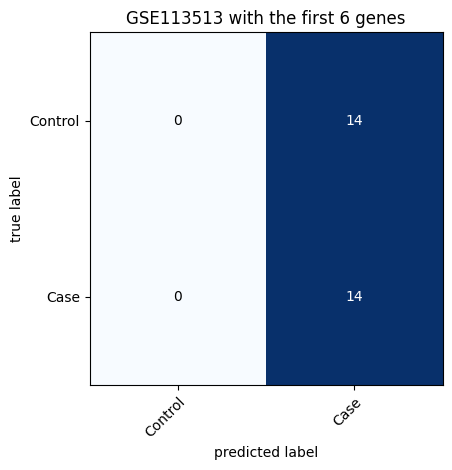

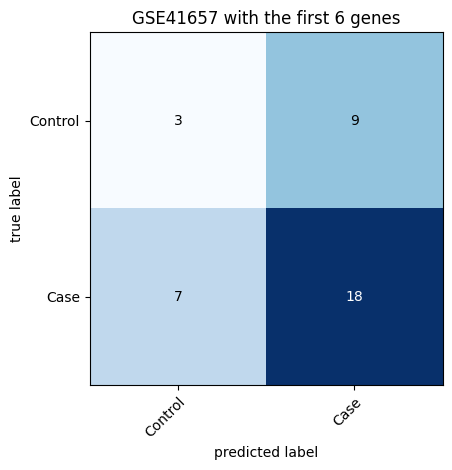

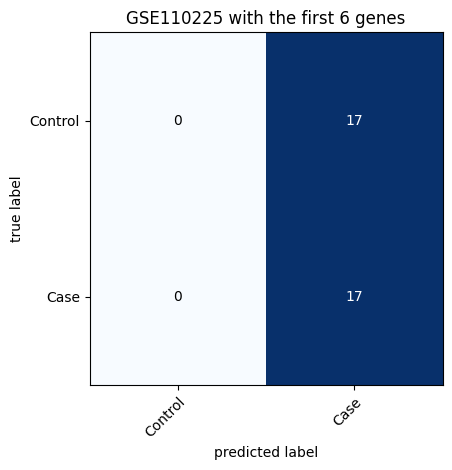

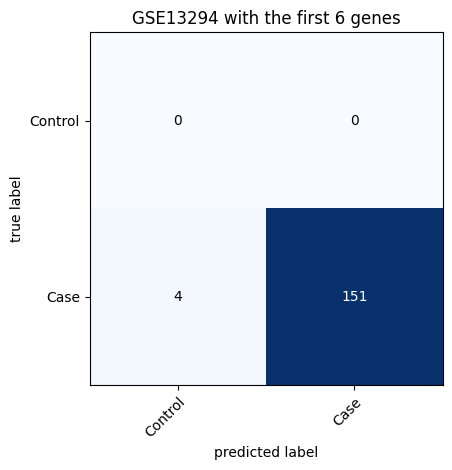

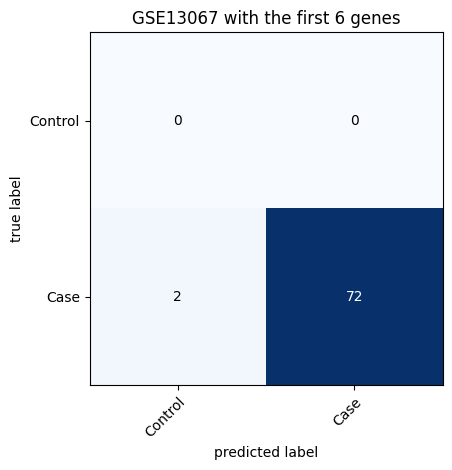

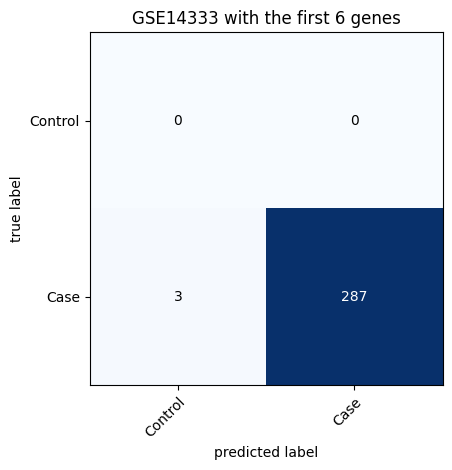

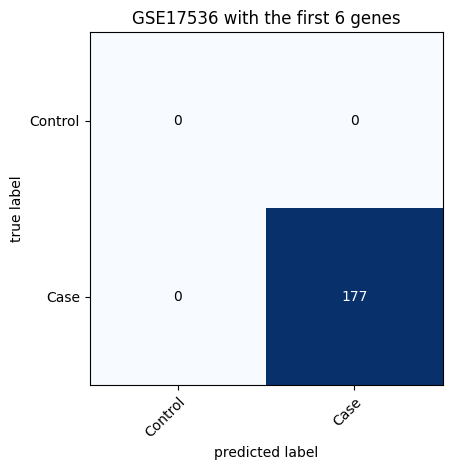

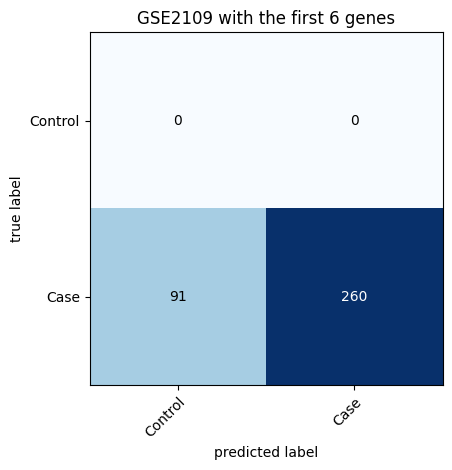

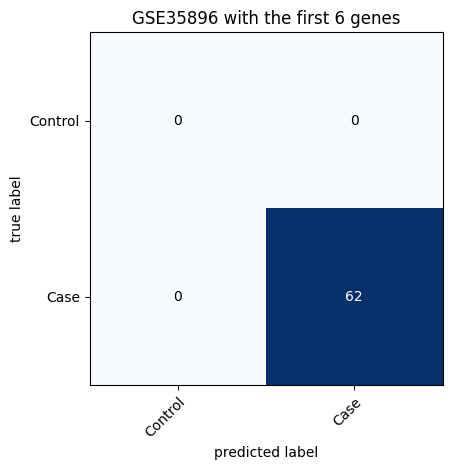

In [4]:
for i in range(len(test_datasets_names)):
    cm = confusions[i]
    helper.plot_confusion_matrix(6, confusions[i], class_names= ['Control','Case'], name=test_datasets_names[i])

In [5]:
controls_diagnosed_as_case = 0
total_controls = 0
cases_diagnosed_as_control = 0
total_cases = 0

for cm in confusions:
    controls_diagnosed_as_case = controls_diagnosed_as_case + cm[0,1]
    total_controls = total_controls + cm[0,0] + cm[0,1]
    cases_diagnosed_as_control = cases_diagnosed_as_control + cm[1,0]
    total_cases = total_cases + cm[1,0] + cm[1,1]

print(f'Total Cases: {total_cases}')
print(f'Cases misdiagnosed as controls: {cases_diagnosed_as_control}')
print(f'Total Controls: {total_controls}')
print(f'Controls misdiagnosed as cases: {controls_diagnosed_as_case}')

Total Cases: 1791
Cases misdiagnosed as controls: 109
Total Controls: 103
Controls misdiagnosed as cases: 100
